# Modeling Spatial Data with Gaussian Processes in PyMC

In this notebook I will recreat the code from [Luciano Paz](https://www.pymc-labs.io/blog-posts/spatial-gaussian-process-01/) with the goal of predicting expected concentrations of radioactive in households depending on the county of the house.

Usually we would picture some kind of continiuos lateng geographical feature that makes observations taken from nearby places be similar to each other. This is diferent from the notion of treating geographical information as a categorical value that grouped observations together. 

One way to get the continium, and avoiding the notion of neighbours to have absolutly nothing in common, is to use Gaussina Processes to model it. GP provides a very nice and flexible way of setting a prior, that essentially says: "nearby observations should be similar to each other, and as the observations go further away, they become uncorrelated. 

## The dataset

In this exercise, the dataset is [the radon dataset from Gelman and Hill 2006](https://www.cambridge.org/highereducation/books/data-analysis-using-regression-and-multilevel-hierarchical-models/32A29531C7FD730C3A68951A17C9D983#overview) where they studied a dataset of radon meassurements that were performed in 919 households from 85 counties of the state of Minnesota. They used a grouping approach, which doesn't have any sense, why should the radon concentration in earth crust follows some county border line? 

In [1]:
import arviz as az
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np
import pandas as pd
import pymc as pm
from aesara import tensor as at
from matplotlib import pyplot as plt

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Cartopy can be used to get the shape files from some public sources, like the Natural Earth. The county shapes have a lot of meta information. One important fields is called FIPS, that stands for [Federal Information Processing Systems](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standards). At the time the radon measurements were performed, the counties were identified using their FIPS codes, and we will use these to align our observations to the corresponding shape files.

In [2]:
# load the dataset:

df = pd.read_csv('data/radon.csv', index_col=0, dtype={"fips":int})
df['fips'] = "US" + df['fips'].astype(str)
county_idx, counties = df.county.factorize(sort=True)
unique_fips = df.fips.unique()
df

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,US27001,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,US27001,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,US27001,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,US27001,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,US27003,0.428565,1,1.163151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,5995.0,MN,MN,27.0,55363,5.0,1.0,0.0,4.0,Y,...,4.5,1146.499190,0.0,0.0,171.0,WRIGHT,US27171,0.913909,83,1.871802
915,5996.0,MN,MN,27.0,55376,5.0,1.0,0.0,7.0,Y,...,8.3,1105.956867,0.0,0.0,171.0,WRIGHT,US27171,0.913909,83,1.526056
916,5997.0,MN,MN,27.0,55376,5.0,1.0,0.0,4.0,Y,...,5.2,1214.922779,0.0,0.0,171.0,WRIGHT,US27171,0.913909,83,1.629241
917,5998.0,MN,MN,27.0,56297,5.0,1.0,0.0,4.0,Y,...,9.6,1177.377355,0.0,0.0,173.0,YELLOW MEDICINE,US27173,1.426590,84,1.335001


In [3]:
# Get the state of Minnesota shapefile
reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_1_states_provinces"
    )
)
minnesota = [
    s
    for s in reader.records()
    if s.attributes["admin"] == "United States of America"
    and s.attributes["name"] == "Minnesota"
][0]

In [4]:
# Get Minnesota counties and neighboring counties shape files
reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_2_counties"
    )
)
minnesota_counties = [
    county
    for county in reader.records()
    if county.geometry.intersects(minnesota.geometry)
    and county.geometry.difference(minnesota.geometry).area / county.geometry.area
    < 0.01
]
minnesota_neighbor_counties = [
    county
    for county in reader.records()
    if county.geometry.intersects(minnesota.geometry)
    and county.geometry.difference(minnesota.geometry).area / county.geometry.area > 0.5
]
counties_with_measurements = [
    c for c in minnesota_counties if c.attributes["FIPS"] in unique_fips
]
counties_without_measurements = [
    c for c in minnesota_counties if c.attributes["FIPS"] not in unique_fips
]
len(counties_with_measurements), len(counties_without_measurements), len(
    minnesota_neighbor_counties
)

(85, 2, 37)

In [5]:
counties_without_measurements

[<Record: <shapely.geometry.polygon.Polygon object at 0x7f6a7d8a5030>, {'FEATURECLA': 'Admin-2 scale rank', 'SCALERANK': 0, 'ADM2_CODE': 'USA-27051', 'ISO_3166_2': 'US-27', 'ISO_A2': 'US', 'ADM0_SR': 1, 'NAME': 'Grant', 'NAME_ALT': 'Grant County', 'NAME_LOCAL': '', 'TYPE': 'County', 'TYPE_EN': 'County', 'CODE_LOCAL': '27051', 'REGION': 'MN', 'REGION_COD': '27', 'ABBREV': '', 'AREA_SQKM': 1490, 'SAMEASCITY': 0, 'LABELRANK': 0, 'NAME_LEN': 5, 'MAPCOLOR9': 1, 'MAPCOLOR13': 1, 'FIPS': 'US27051', 'SOV_A3': 'US1', 'ADM0_A3': 'USA', 'ADM0_LABEL': 2, 'ADMIN': 'United States of America', 'GEONUNIT': 'United States of America', 'GU_A3': 'USA', 'MIN_LABEL': 8, 'MAX_LABEL': 10, 'MIN_ZOOM': 6.6, 'WIKIDATAID': 'Q486270', 'NE_ID': 1730092417, 'latitude': 45.933931, 'longitude': -96.012048, 'NAME_AR': 'غرانت', 'NAME_BN': '', 'NAME_DE': 'Grant', 'NAME_EL': '', 'NAME_EN': 'Grant', 'NAME_ES': 'Grant', 'NAME_FA': 'شهرستان گرانت، مینهسوتا', 'NAME_FR': 'Grant', 'NAME_HE': 'מחוז גרנט', 'NAME_HI': '', 'NAME_H

In [6]:
county_fips = {counties[idx]: df.fips.iloc[i] for i, idx in enumerate(county_idx)}
fips_to_records = {
    record.attributes["FIPS"]: record for record in counties_with_measurements
}
county_to_records = {c: fips_to_records[county_fips[c]] for c in counties}
county_lonlat = {
    c: np.array(
        [
            county_to_records[c].attributes["longitude"],
            county_to_records[c].attributes["latitude"],
        ]
    )
    for c in counties
}
cond_counties = [
    c.attributes["NAME"].upper() for c in counties_without_measurements
] + [
    f"{c.attributes['NAME']} - {c.attributes['REGION']}".upper()
    for c in minnesota_neighbor_counties
]
county_to_records.update(
    {
        name: record
        for name, record in zip(
            cond_counties, counties_without_measurements + minnesota_neighbor_counties
        )
    }
)
cond_county_lonlat = {
    c: np.array(
        [
            county_to_records[c].attributes["longitude"],
            county_to_records[c].attributes["latitude"],
        ]
    )
    for c in cond_counties
}

/root/bruno/learning-projects/machine_learning_projects/GaussianProcessLearning/gaussian_process/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/root/bruno/learning-projects/machine_learning_projects/GaussianProcessLearning/gaussian_process/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


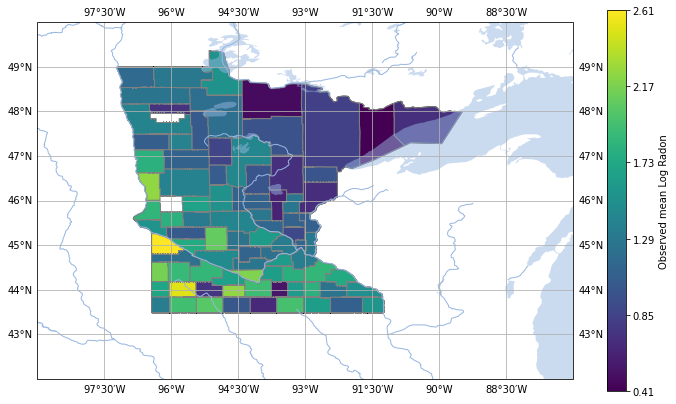

In [7]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.add_feature(
    cfeature.ShapelyFeature([minnesota.geometry], projection),
    edgecolor="k",
    facecolor="w",
)
expected_radon = df.groupby("county")["log_radon"].mean()
vmin = expected_radon.min()
vmax = expected_radon.max()
color_getter = lambda x: plt.get_cmap("viridis")(np.interp(x, [vmin, vmax], [0, 1]))
for county in counties:
    county_record = county_to_records[county]
    val = expected_radon[county]
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], projection),
        edgecolor="gray",
        facecolor=color_getter(val.data),
    )

cbar = fig.colorbar(plt.matplotlib.cm.ScalarMappable(norm=None, cmap="viridis"))
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(
    [f"{round(np.interp(x, [0, 1], [vmin, vmax]), 2)}" for x in cbar.get_ticks()]
)
cbar.set_label("Observed mean Log Radon")
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.set_xlim([-99, -87])
ax.set_ylim([42, 50])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

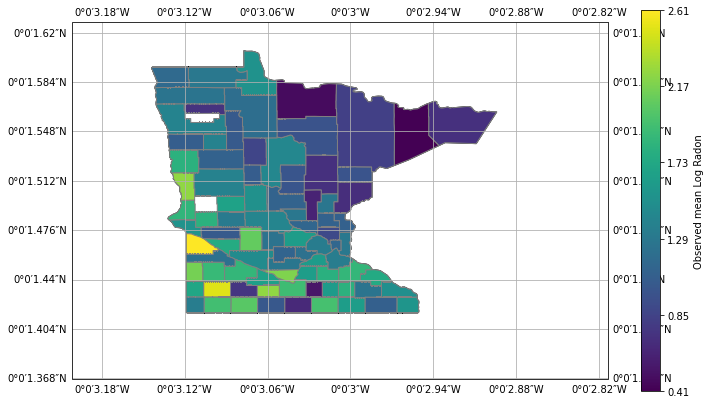

In [10]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.Geostationary()
ax = plt.axes(projection=projection)
ax.add_feature(
    cfeature.ShapelyFeature([minnesota.geometry], projection),
    edgecolor="k",
    facecolor="w",
)
expected_radon = df.groupby("county")["log_radon"].mean()
vmin = expected_radon.min()
vmax = expected_radon.max()
color_getter = lambda x: plt.get_cmap("viridis")(np.interp(x, [vmin, vmax], [0, 1]))
for county in counties:
    county_record = county_to_records[county]
    val = expected_radon[county]
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], projection),
        edgecolor="gray",
        facecolor=color_getter(val.data),
    )

cbar = fig.colorbar(plt.matplotlib.cm.ScalarMappable(norm=None, cmap="viridis"))
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(
    [f"{round(np.interp(x, [0, 1], [vmin, vmax]), 2)}" for x in cbar.get_ticks()]
)
cbar.set_label("Observed mean Log Radon")
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.set_xlim([-99, -87])
ax.set_ylim([42, 50])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

We can see a small pattern forming here. It looks like radon is denser to the south west, and sparser in the north east. We're almost ready to take this data to the next level!

## Gaussian Process on a Sphere

Even though the above plot seems flat, the earth is round (kind of):

![](https://www.pymc-labs.io/blog-posts/spatial-gaussian-process-01/output_22_0.png)

And this makes it a bit harder to define a gaussian process. Thankfully, there is a [review paper by Jeong Jun and Genton](https://marcgenton.github.io/2017.JJG.StatSci.pdf) that talks exactly how one could write down covariance functions for Gaussian Process that occur on the surface of a sphere. In this case we will use the Matérn kernel that relies on the chordal distance between points. The chordal distance is simply the distance between two points on the surface of the Earth, if you could travel between them using a straight line that went through the planet. On the other hand, the geodesic distance is the shortest between two points if one was forced to travel on the surface of the globe. 

![](https://www.pymc-labs.io/blog-posts/spatial-gaussian-process-01/chordal_geodesic.png)

### Custom PyMC covariance kernel on a sphere

PyMC comes with many covariance kernels, but they all assume that the distance between two points is the euclidean distance. Since we will working the longitude and latitude, we need to build our own *Covariance* subclass that operates using the metric we actually want, the chordal distance between points on a sphere. 

To do this, we basically need to inherit from **pymc.gp.cov.Stationary** and overload the **full** method. This method computes the covariance between a set of points. To do this, we will copy the implementation from **pymc.gp.cov.Matern32** but change the distance function used. Instead of using the assumed *euclidean_dist* we will write a custom method the *chordal_dist*. To compute the chordal distance, we only need to convert the longitude/latitude coordinates into their 3D position counterparts. The chordal distance is them simply the euclidean distance between the 3D position coordinates. 

In [18]:
class Matern32Chordal(pm.gp.cov.Stationary):
    def __init__(self, input_dims, ls, r=6378.137, active_dims=None):
        if input_dims != 2:
            raise ValueError("Chordal distance is only defined on 2 dimensions")
        super().__init__(input_dims, ls=ls, active_dims=active_dims)
        self.r = r

    def lonlat2xyz(self, lonlat):
        lonlat = np.deg2rad(lonlat)
        return self.r * at.stack(
            [
                at.cos(lonlat[..., 0]) * at.cos(lonlat[..., 1]),
                at.sin(lonlat[..., 0]) * at.cos(lonlat[..., 1]),
                at.sin(lonlat[..., 1]),
            ],
            axis=-1,
        )

    def chordal_dist(self, X, Xs=None):
        if Xs is None:
            Xs = X
        X, Xs = at.broadcast_arrays(
            self.lonlat2xyz(X[..., :, None, :]), self.lonlat2xyz(Xs[..., None, :, :])
        )
        return at.sqrt(at.sum(((X - Xs) / self.ls) ** 2, axis=-1) + 1e-12)

    def full(self, X, Xs=None):
        X, Xs = self._slice(X, Xs)
        r = self.chordal_dist(X, Xs)
        return (1.0 + np.sqrt(3.0) * r) * at.exp(-np.sqrt(3.0) * r)

## Gaussian Process Geospatial Model:

Now we are finally ready to write our PyMC model of the geospatial dataset

In [21]:
X = np.array(list(county_lonlat.values()))
coords = {
        "county": counties,
        "household": df.index,
        "feature": ["longitude", "latitude"],
    }
with pm.Model(coords = coords) as m:
    _county_idx = pm.ConstantData("county_idx", county_idx, dims="household")
    _X = pm.ConstantData("county_X", X, dims=("county", "feature"))

Now, we wil basically assume that the observed radon comes from a state level mean plus some deviation due to the county. The county deviation will be represented by a GP. Let's first create the state level random variables:

In [22]:
with m:
    state_mu = pm.Normal("state_mu", 0, 3)
    state_scale = pm.HalfNormal("state_scale", 0.7)

We create the GP prior for the county deviations. We will try to infer the lenght scale and a priori assume that it's around 200 km with a standard deviations of about 50 km. 

In [23]:
with m:
    ls = pm.Gamma("ls", mu=200, sigma=50)
    latent = pm.gp.Latent(cov_func=Matern32Chordal(2, ls),)
    county_eps = latent.prior("county_eps", _X, dims="county", jitter=1e-7)

We piece everything together and compute the expected radon measurement of each household:

In [24]:
with m:
    county_mu = pm.Deterministic(
        "county_mu", state_mu + state_scale * county_eps, dims="county"
    )
    household_mu = county_mu[_county_idx]

Now, the final piece of the puzzle: the observational distribution. We will model the log radon values:

In [25]:
with m:
    measurement_error = pm.HalfNormal("measurement_error",0.5)
    observed = pm.Normal(
        "log_radon",
        mu=household_mu,
        sigma=measurement_error,
        observed=df.log_radon.values,
        dims='houlsehold',
    )

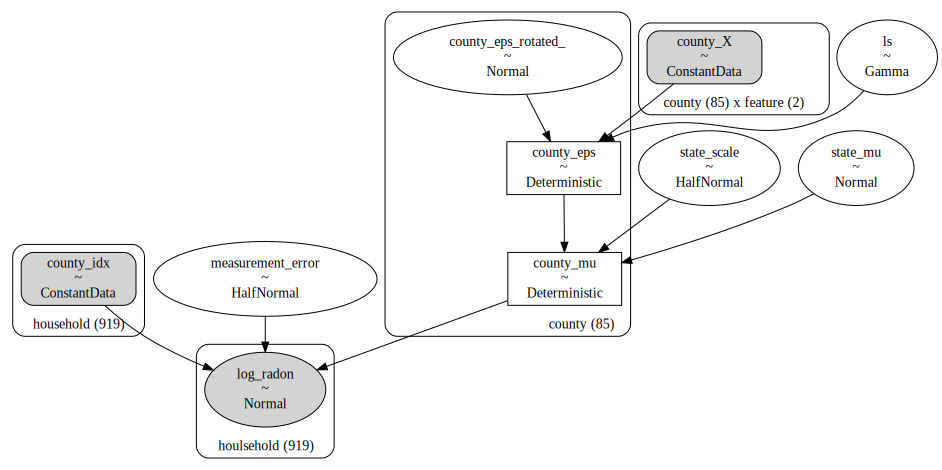

In [28]:
pm.model_to_graphviz(m)

We haven't included any information about whether the radon was recorded at the basement or not. We could exploit this extra information to make the model better. 

Now let's sample from the model and see what the model learns about the measured counties:

In [29]:
with m:
    idata = pm.sample(
        init="jitter+adapt_diag_grad", random_seed=42, chains=4, target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [state_mu, state_scale, ls, county_eps_rotated_, measurement_error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17769 seconds.


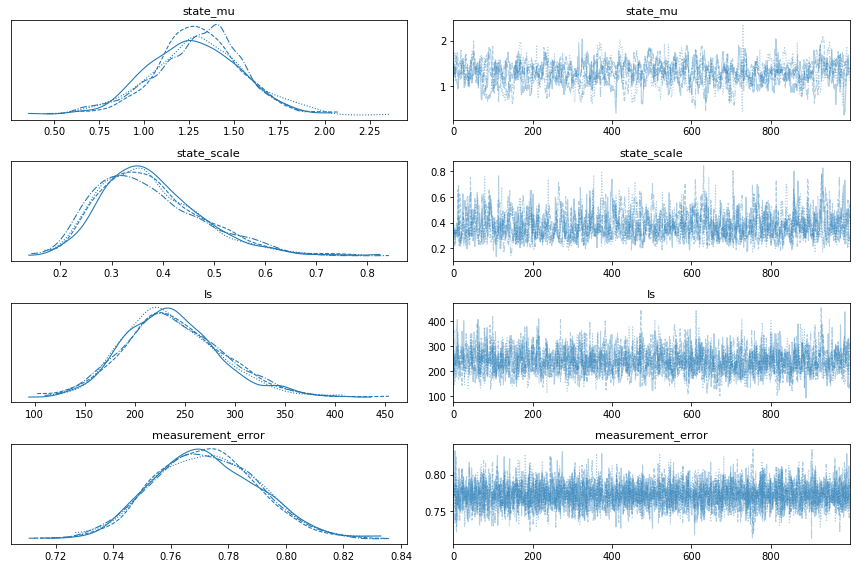

In [30]:
axs = az.plot_trace(idata, var_names=["~county_mu", "~county_eps"], filter_vars="like")
axs[0,0].figure.tight_layout()

Finally, the most important piece, extrapolating what we learned to unobserved counties! To do this, we will have to create conditional GP's on the unobserved coordinates, and then create the conditional observed log radon random variables:

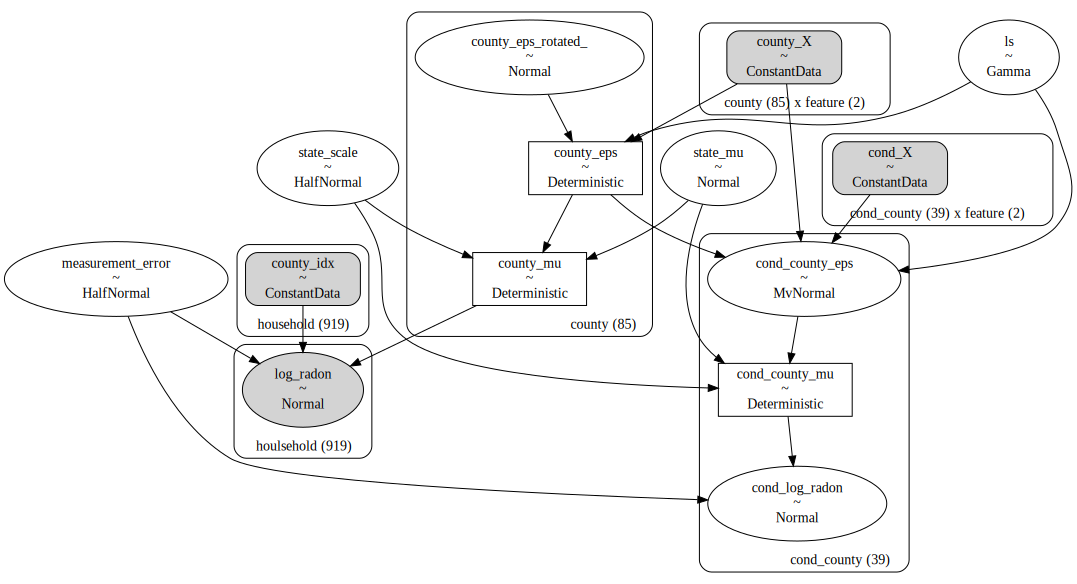

In [31]:
cond_X = np.array(list(cond_county_lonlat.values()))
with m:
    m.add_coords({"cond_county": cond_counties})
    _cond_X = pm.ConstantData("cond_X", cond_X, dims=["cond_county", "feature"])
    cond_county_eps = latent.conditional(
        "cond_county_eps", _cond_X, jitter=1e-3, dims="cond_county"
    )
    cond_mu = pm.Deterministic(
        "cond_county_mu", state_mu + state_scale * cond_county_eps, dims="cond_county"
    )
    observed = pm.Normal(
        "cond_log_radon", mu=cond_mu, sigma=measurement_error, dims=["cond_county"],
    )
pm.model_to_graphviz(m)

Afterwards, predicting on these new counties is as easy as sampling from the posterior predictive distribution.

In [32]:
with m:
    pp = pm.sample_posterior_predictive(
        idata, var_names=["cond_county_mu", "cond_log_radon"], random_seed=42
    )

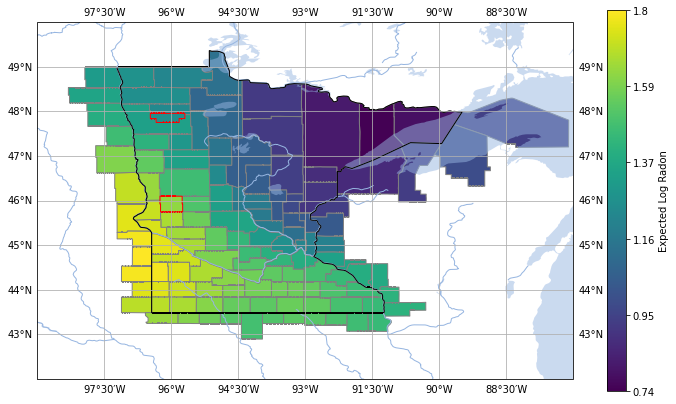

In [33]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
expected_radon = idata.posterior.county_mu.mean(["chain", "draw"])
pp_expected_radon = pp.posterior_predictive.cond_county_mu.mean(["chain", "draw"])
vmin = min([expected_radon.min().data, pp_expected_radon.min().data])
vmax = max([expected_radon.max().data, pp_expected_radon.max().data])
color_getter = lambda x: plt.get_cmap("viridis")(np.interp(x, [vmin, vmax], [0, 1]))
for county in counties:
    county_record = county_to_records[county]
    val = expected_radon.sel(county=county)
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], projection),
        edgecolor="gray",
        facecolor=color_getter(val.data),
    )
for county in cond_counties:
    county_record = county_to_records[county]
    if county_record in counties_without_measurements:
        edgecolor = "red"
    else:
        edgecolor = "gray"
    val = pp_expected_radon.sel(cond_county=county)
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], projection),
        edgecolor=edgecolor,
        facecolor=color_getter(val.data),
    )

cbar = fig.colorbar(plt.matplotlib.cm.ScalarMappable(norm=None, cmap="viridis"))
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(
    [f"{round(np.interp(x, [0, 1], [vmin, vmax]), 2)}" for x in cbar.get_ticks()]
)
cbar.set_label("Expected Log Radon")
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.set_xlim([-99, -87])
ax.set_ylim([42, 50])
ax.add_feature(
    cfeature.ShapelyFeature([minnesota.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False);